In [5]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten
from keras.layers import dot
from pylab import rcParams

In [6]:
# reading the data files 
movies = pd.read_fwf(r"C:\Users\suraj\Downloads\zee-movies.dat", encoding='ISO-8859-1')
ratings = pd.read_fwf(r"C:\Users\suraj\Downloads\zee-ratings.dat", encoding='ISO-8859-1')
users = pd.read_fwf(r"C:\Users\suraj\Downloads\zee-users.dat", encoding='ISO-8859-1')

# Data Formatting

Movies

In [7]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [8]:
# removing the columns with NaN
movies.drop(columns = ['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace = True)
movies.head(2)

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy


In [9]:
# Now lets make columns separating based on :: 
delimiter = '::'
movies = movies['Movie ID::Title::Genres'].str.split(delimiter, expand = True)
movies.columns = ['Movie ID', 'Title', 'Genres']
movies.head(2)

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [10]:
movies.rename(columns = {'Movie ID' : 'MovieID'}, inplace = True)

In [11]:
movies.head(2)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


Ratings

In [12]:
ratings.head(2)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109


In [13]:
# lets split and make columns for the ratings also as we did it for the movies
delimiter = '::'
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter, expand = True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings.head(2)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


Users 

In [14]:
users.head(3)

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117


In [15]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users.head(3)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


In [16]:
users['Age'].value_counts()
# users['Occupation'].value_counts()

Age
25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: count, dtype: int64

In [17]:
# lets replace with age and occupation as given from users 
users.replace({'Age' : {
    '1' : "Under 18",
    '18':  "18-24",
    '35':  "35-44",
    '25':  "25-34",
    '45':  "45-49",
    '50':  "50-55",
    '56':  "56 Above"

}}, inplace = True)

users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [18]:
users.head(5)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,k-12 student,48067
1,2,M,56 Above,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


Merging the dataframes

In [19]:
df_1 = pd.merge(movies, ratings, how='inner', on='MovieID')
df_1.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


In [20]:
df_2 = pd.merge(df_1, users, how='inner', on='UserID')
df_2.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25-34,programmer,11413
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25-34,technician/engineer,61614
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35-44,academic/educator,95370


In [21]:
data = df_2.copy(deep=True)
data

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25-34,programmer,11413
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25-34,technician/engineer,61614
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35-44,academic/educator,95370
...,...,...,...,...,...,...,...,...,...,...
1000204,3952,"Contender, The (2000)",Drama|Thriller,5812,4,992072099,F,25-34,executive/managerial,92120
1000205,3952,"Contender, The (2000)",Drama|Thriller,5831,3,986223125,M,25-34,academic/educator,92120
1000206,3952,"Contender, The (2000)",Drama|Thriller,5837,4,1011902656,M,25-34,executive/managerial,60607
1000207,3952,"Contender, The (2000)",Drama|Thriller,5927,1,979852537,M,35-44,sales/marketing,10003


# EDA

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      996144 non-null   object
 3   UserID      1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Timestamp   1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  object
 8   Occupation  1000209 non-null  object
 9   Zip-code    1000209 non-null  object
dtypes: object(10)
memory usage: 76.3+ MB


# Feature Engineering

In [23]:
data['Rating'].unique()

array(['5', '4', '3', '2', '1'], dtype=object)

As it is in categorical lets convert it into integer

In [24]:
data['Rating'] = data['Rating'].astype('int32')

In [25]:
data['Datetime'] = pd.to_datetime(data['Timestamp'],
                                  unit='s')

C:\Users\suraj\AppData\Local\Temp\ipykernel_2240\606865118.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['Datetime'] = pd.to_datetime(data['Timestamp'],


In [26]:
data.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117,2000-12-31 04:30:08
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25-34,programmer,11413,2000-12-31 03:31:36
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25-34,technician/engineer,61614,2000-12-31 01:25:52
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35-44,academic/educator,95370,2000-12-31 01:34:34


In [27]:
# pip install --upgrade pandas

In [28]:
data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s')
data.info()

C:\Users\suraj\AppData\Local\Temp\ipykernel_2240\1440960711.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['Datetime'] = pd.to_datetime(data['Timestamp'], unit='s')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   MovieID     1000209 non-null  object        
 1   Title       1000209 non-null  object        
 2   Genres      996144 non-null   object        
 3   UserID      1000209 non-null  object        
 4   Rating      1000209 non-null  int32         
 5   Timestamp   1000209 non-null  object        
 6   Gender      1000209 non-null  object        
 7   Age         1000209 non-null  object        
 8   Occupation  1000209 non-null  object        
 9   Zip-code    1000209 non-null  object        
 10  Datetime    1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(9)
memory usage: 80.1+ MB


In [29]:
data.head()

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117,2000-12-31 04:30:08
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25-34,programmer,11413,2000-12-31 03:31:36
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,25-34,technician/engineer,61614,2000-12-31 01:25:52
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474,F,35-44,academic/educator,95370,2000-12-31 01:34:34


In [30]:
data['ReleaseYear'] = data['Title'].str.extract(r'\((\d{4})\)')
# data['ReleaseYear'] = data['ReleaseYear'].str.lstrip("(").str.rstrip(")")

In [31]:
data = data.dropna(subset=['ReleaseYear'])

In [32]:
data['ReleaseYear'].unique()

array(['1995', '1994', '1996', '1976', '1993', '1992', '1988', '1967',
       '1964', '1977', '1965', '1982', '1962', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1956', '1959', '1968', '1980', '1975', '1948', '1943', '1950',
       '1987', '1997', '1974', '1958', '1972', '1998', '1952', '1951',
       '1957', '1961', '1954', '1934', '1944', '1963', '1942', '1941',
       '1953', '1939', '1947', '1946', '1945', '1938', '1935', '1936',
       '1926', '1949', '1932', '1930', '1971', '1979', '1986', '1966',
       '1978', '1985', '1983', '1984', '1933', '1931', '1922', '1927',
       '1929', '1928', '1999', '1925', '1919', '1923', '2000', '1920',
       '1921'], dtype=object)

In [33]:
data['ReleaseYear'] = data['ReleaseYear'].astype(int)

C:\Users\suraj\AppData\Local\Temp\ipykernel_2240\2010661776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ReleaseYear'] = data['ReleaseYear'].astype(int)


In [34]:
data.head(3)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,1995
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117,2000-12-31 04:30:08,1995
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496,M,25-34,programmer,11413,2000-12-31 03:31:36,1995


In [35]:
data['Title'] = data['Title'].str.replace(r'\s*\(\d{4}\)$', '', regex = True)

C:\Users\suraj\AppData\Local\Temp\ipykernel_2240\3862611213.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Title'] = data['Title'].str.replace(r'\s*\(\d{4}\)$', '', regex = True)


In [36]:
data.head(2)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear
0,1,Toy Story,Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,1995
1,1,Toy Story,Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117,2000-12-31 04:30:08,1995


In [37]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDec'] = pd.cut(data['ReleaseYear'], bins = bins, labels = labels)

C:\Users\suraj\AppData\Local\Temp\ipykernel_2240\3505609566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ReleaseDec'] = pd.cut(data['ReleaseYear'], bins = bins, labels = labels)


In [38]:
data.head(1)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear,ReleaseDec
0,1,Toy Story,Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,1995,90s


Checking for null values

In [39]:
data.isna().sum()

MovieID          0
Title            0
Genres         521
UserID           0
Rating           0
Timestamp        0
Gender           0
Age              0
Occupation       0
Zip-code         0
Datetime         0
ReleaseYear      0
ReleaseDec      45
dtype: int64

Checking for duplicate rows

In [40]:
duplicate_rows = data[data.duplicated()]
print("No. of duplicate rows: ", duplicate_rows.shape[0])

No. of duplicate rows:  0


# Data Visualization

Distribution of Movie Ratings

In [41]:
data.head(2)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear,ReleaseDec
0,1,Toy Story,Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,1995,90s
1,1,Toy Story,Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117,2000-12-31 04:30:08,1995,90s


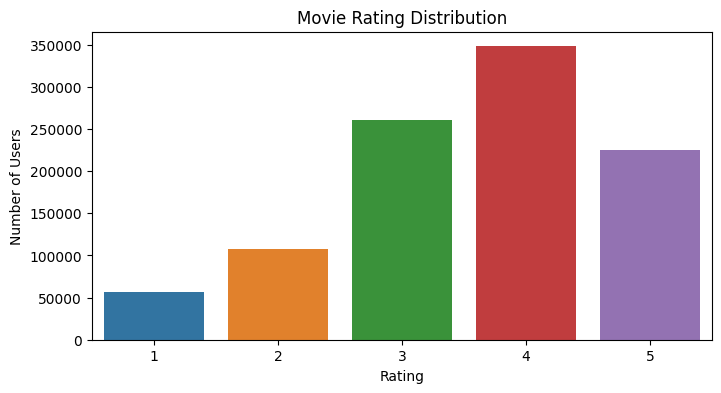

In [42]:
plt.figure(figsize = (8, 4))
sns.countplot(x='Rating', data=data)
plt.title("Movie Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Users")
plt.show()

We can observe that the rating 4 has the highest number of count

Distribution by Age

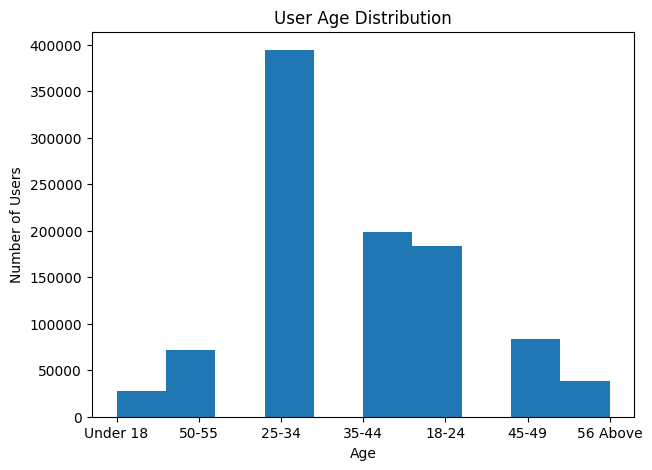

In [43]:
data['Age'].hist(figsize=(7, 5))
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.grid(False)
plt.show()

Distribution By gender

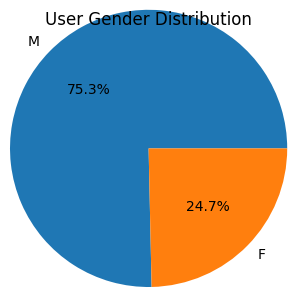

Gender
M    750941
F    245724
Name: count, dtype: int64

In [44]:
x = data['Gender'].value_counts().values
plt.figure(figsize=(6, 3))
plt.pie(x, center = (0, 0), radius = 1.5, labels = ['M', 'F'], autopct='%1.1f%%')
plt.title('User Gender Distribution')
# plt.axis('equal')
plt.show()
data['Gender'].value_counts()

Distribution by Occupation

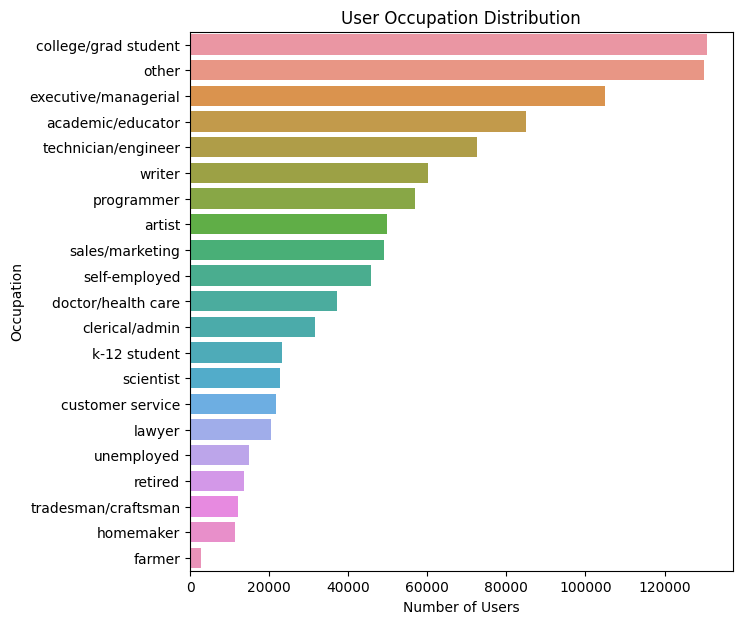

In [45]:
plt.figure(figsize=(7, 7))
sns.countplot(y='Occupation', data=data, order=data['Occupation'].value_counts().index)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

Distribution by Release Year

In [46]:
data.head(2)

,MovieID,Title,Genres,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datetime,ReleaseYear,ReleaseDec
0,1,Toy Story,Animation|Children's|Comedy,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,1995,90s
1,1,Toy Story,Animation|Children's|Comedy,6,4,978237008,F,50-55,homemaker,55117,2000-12-31 04:30:08,1995,90s


c:\Users\suraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


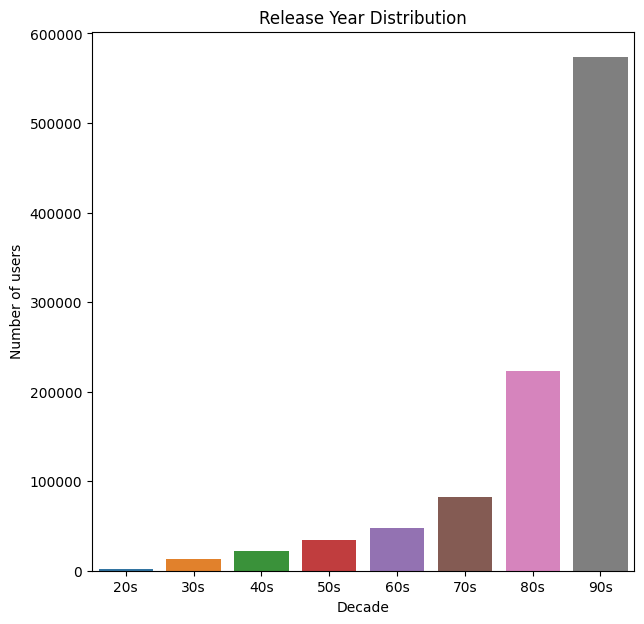

In [47]:
plt.figure(figsize=(7, 7))
sns.countplot(x = 'ReleaseDec', data = data)
plt.title("Release Year Distribution")
plt.xlabel('Decade')
plt.ylabel("Number of users")
plt.show()

# Grouping the data

Average Rate

In [48]:
data.groupby('Title')['Rating'].mean().sort_values(ascending = False).head(5)

Title
Lured                          5.0
Smashing Time                  5.0
Gate of Heavenly Peace, The    5.0
One Little Indian              5.0
Follow the Bitch               5.0
Name: Rating, dtype: float64

No of ratings

In [49]:
data.groupby('Title')['Rating'].count().sort_values(ascending = False).head(5)

Title
American Beauty                                   3428
Star Wars: Episode IV - A New Hope                2991
Star Wars: Episode V - The Empire Strikes Back    2990
Star Wars: Episode VI - Return of the Jedi        2883
Jurassic Park                                     2672
Name: Rating, dtype: int64

In [50]:
df = pd.DataFrame(data.groupby('Title')['Rating'].agg([('Avg rating', 'mean')]))
df['No. of ratings'] = pd.DataFrame(data.groupby('Title')['Rating'].count())
df.head(3)

,Avg rating,No. of ratings
Title,,
"$1,000,000 Duck",3.027027,37
'Night Mother,3.371429,70
'Til There Was You,2.692308,52


In our case, we will be working on a Collaborative Filtering Recommender System.
Collaborative filtering methods are classified as memory-based and model-based.
Also there are two approaches to this method. A user-based approach and an item-based approach

# Pivot Table

Creating a pivot table of movie title and user_id

In [51]:
matrix = pd.pivot_table(data, index = 'UserID', columns = 'Title', values = 'Rating', aggfunc = 'mean')
matrix.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0


Imputing 'NaN' values with Zero rating

In [52]:
matrix.fillna(0, inplace = True)
matrix.head(3)

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
matrix.shape

(6040, 3646)

# Pearson Correlation

Correlation is a measure that tells how closely two variables move in the same or opposite direction. A positive value indicates that they move in the same direction (i.e. if one increases other increases), where as negative value indicates the opposite 

The most popular correlation measure for numerical data is Pearson's Correlatio. This measures the degree of linear relationship between two numeric variables and lies between -1 to +1. It is represented by 'r'

    r=1 means perfect positive correlation
    r=-1 means perfect negative correlation
    r=0 means no linear correlation (note, it does not mean no correlation)

# Item Based Approach

We will take a movie name as an input from the user and see which other five movies have maximum correlation with it

In [54]:
movie_name = 'Liar Liar'

In [ ]:
movie_rating = matrix[movie_name]


UserID
1       0.0
10      0.0
100     0.0
1000    0.0
1001    0.0
       ... 
995     0.0
996     0.0
997     0.0
998     0.0
999     0.0
Name: Liar Liar, Length: 6040, dtype: float64


In [57]:
similar_movies = matrix.corrwith(movie_rating)

In [59]:
sim_df = pd.DataFrame(similar_movies, columns = ['Correlation'])
sim_df.sort_values('Correlation', ascending = False, inplace = True)

In [60]:
sim_df.iloc[1:, :].head()

,Correlation
Title,
Mrs. Doubtfire,0.499927
Dumb & Dumber,0.459601
Ace Ventura: Pet Detective,0.458654
Home Alone,0.455967
"Wedding Singer, The",0.429222


# Cosine Similarity

Cosine similarity is a measure of similarity between two sequences of numbers. Those sequences are viewed as vectors in a higher dimensional space, and the cosine similarity defined as the cosine of the angle between them, i.e. the dot product of the vectors divided by the product of their lengths.

The cosine similarity always belongs to the interval [-1, 1]. For example, two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1

In [61]:
item_sim = cosine_similarity(matrix.T)
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

Item similarity matrix

In [62]:
item_sim_mat = pd.DataFrame(item_sim, index = matrix.columns, columns = matrix.columns)
item_sim_mat.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


In [63]:
user_sim = cosine_similarity(matrix)
user_sim

array([[1.        , 0.25531859, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12239079],
       [0.25531859, 1.        , 0.25964457, ..., 0.16569953, 0.13332665,
        0.24845029],
       [0.12396703, 0.25964457, 1.        , ..., 0.20430203, 0.11352239,
        0.30693676],
       ...,
       [0.15926709, 0.16569953, 0.20430203, ..., 1.        , 0.18657496,
        0.18563871],
       [0.11935626, 0.13332665, 0.11352239, ..., 0.18657496, 1.        ,
        0.10827118],
       [0.12239079, 0.24845029, 0.30693676, ..., 0.18563871, 0.10827118,
        1.        ]])

User similarity matrix

In [87]:
user_sim_mat = pd.DataFrame(user_sim, index=matrix.index, columns=matrix.index)
user_sim_mat.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255319,0.123967,0.207800,0.139317,0.110320,0.121384,0.180226,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.255319,1.000000,0.259645,0.280479,0.158703,0.112917,0.141985,0.432536,0.194915,0.102487,...,0.154412,0.186234,0.083739,0.125894,0.118558,0.146552,0.304806,0.165700,0.133327,0.248450
100,0.123967,0.259645,1.000000,0.306067,0.075736,0.110450,0.358686,0.237492,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.280479,0.306067,1.000000,0.099117,0.047677,0.201722,0.355920,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139317,0.158703,0.075736,0.099117,1.000000,0.164854,0.053887,0.150196,0.138602,0.134710,...,0.146270,0.026891,0.097011,0.119609,0.092234,0.109700,0.222119,0.103255,0.269952,0.178399


Nearest Neighbours

In [88]:
csr_mat = sparse.csr_matrix(matrix.T.values)
csr_mat

<3646x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 993541 stored elements in Compressed Sparse Row format>

A sparse matrix or sparse array is a matrix in which most of the elements are zero. A compressed sparse row (csr) matrix 'M' is representes by three (one-dimensional) array that respectively contain nonzero values, the extents of rows, and column indices. The CSR format stores a sparse m x n matrix M in row form using three (one-dimensional) arrays (COL_INDEX, ROW_INDEX)

For Example

Dense matrix representation:

[[1 0 0 0 0 0]

[0 0 2 0 0 1]

[0 0 0 2 0 0]]

Sparse 'row' matrix:

(0, 0) 1

(1, 2) 2

(1, 5) 1

(2, 3) 2

Fitting the model with 'cosine similarity' as the distance metric and 5 (five) as the no. of nearest neighbors

In [94]:
knn  = NearestNeighbors(n_neighbors=5, metric = 'cosine', n_jobs=1)
knn.fit(csr_mat)

NearestNeighbors(metric='cosine', n_jobs=1)

Lets make recommendations for a movie of the user's choice

In [95]:
movie_name = 'Liar Liar'
movie_index = matrix.columns.get_loc(movie_name)

In [96]:
distances, indices = knn.kneighbors(matrix[movie_name].values.reshape(1, -1), n_neighbors = 11)

In [97]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print("Recommendations for the movie: {0}\n".format(movie_name))
    else:
        print('{0}: {1}, with distance of {2}'.format(i, matrix.columns[indices.flatten()[i]], round(distances.flatten()[i], 3)))

Recommendations for the movie: Liar Liar

1: Mrs. Doubtfire, with distance of 0.443
2: Ace Ventura: Pet Detective, with distance of 0.483
3: Dumb & Dumber, with distance of 0.487
4: Home Alone, with distance of 0.489
5: Wayne's World, with distance of 0.501
6: Wedding Singer, The, with distance of 0.503
7: Austin Powers: International Man of Mystery, with distance of 0.511
8: There's Something About Mary, with distance of 0.517
9: League of Their Own, A, with distance of 0.518
10: Mask, The, with distance of 0.531


# Matrix Factorizarion

First we need to create embeddings for both the user as well as the item or movie. For this we have used the Embedding layer from keras

In [98]:
# Creating embeddings for both users and movies
users = data.UserID.unique()
movies = data.MovieID.unique()

userid2idx = {o:i for i, o in enumerate(users)} 
movieid2idx = {o:i for i, o in enumerate(movies)}

The number of dimensions (Latent Factors) in the embeddings is a hyperparameter to deal with in this implementation of collaborative filtering

In [99]:
data['UserID'] = data['UserID'].apply(lambda x: userid2idx[x])
data['MovieID'] = data['MovieID'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(data))<0.8
train = data[split]
valid = data[~split]
print(train.shape, valid.shape)

C:\Users\suraj\AppData\Local\Temp\ipykernel_2240\1502675303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['UserID'] = data['UserID'].apply(lambda x: userid2idx[x])
C:\Users\suraj\AppData\Local\Temp\ipykernel_2240\1502675303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MovieID'] = data['MovieID'].apply(lambda x: movieid2idx[x])


(797877, 13) (198788, 13)


In [111]:
n_movies = len(data['MovieID'].unique())
n_users = len(data['UserID'].unique())

n_latent_factors = 64

Specify the input expected to be embedded (Both in user and item embedding). Then user Embedding layer which expects the number of latents factors in the resulting embedding also the number of users or items

In [113]:
user_input = Input(shape = (1, ), name = 'user_input', dtype = 'int64')
user_embedding = Embedding(input_dim=n_users, output_dim=n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name = 'FlattenUsers')(user_embedding)

In [114]:
movie_input = Input(shape = (1, ), name = 'movie_input', dtype = 'int64')
movie_embedding = Embedding(n_movies, output_dim=n_latent_factors, name = 'movie_embedding')(movie_input)
movie_vec = Flatten(name = 'FlattenMovies')(movie_embedding)

Then we take the 'Dot-Product' of both the embeddings using the 'merge' layer. Note that 'dot-product' is just a measure of simalrity and we can use any other mode like 'mulitply' or 'cosine simalarity' or 'concatenate' etc.

In [115]:
sim = dot([user_vec, movie_vec], name = 'Similarity-Dot-Product', axes = 1)
model = keras.models.Model([user_input, movie_input], sim)

Lastly we make a Keras model from the specified details

In [116]:
model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'mse')

Let's see the model's summary

In [117]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 64)     │    386,560 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 64)     │    236,032 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUsers        │ (None, 64)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenMovies       │ (None, 64)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Similarity-Dot-Pro… │ (None, 1)         │          0 │ FlattenUsers[0][… │
│ (Dot)               │                   │            │ FlattenMovies[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 622,592 (2.38 MB)

 Trainable params: 622,592 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

Note that the metrics used is 'Mean squared Error'. Our aim is to minimize the mse on the training set i.e. over the values which the user has rated.

# Model Training

In [118]:
model_hist = model.fit([train.UserID, train.MovieID], train.Rating, batch_size = 128,
                       epochs = 20, validation_data = ([valid.UserID, valid.MovieID], valid.Rating),
                       verbose = 1)

Epoch 1/20


c:\Users\suraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'movie_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


6234/6234 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 14.0512 - val_loss: 13.3742
Epoch 2/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 11.6506 - val_loss: 5.1640
Epoch 3/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 3.9460 - val_loss: 2.0418
Epoch 4/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.7546 - val_loss: 1.2909
Epoch 5/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.1772 - val_loss: 1.0350
Epoch 6/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.9759 - val_loss: 0.9297
Epoch 7/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.8898 - val_loss: 0.8802
Epoch 8/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.8483 - val_loss: 0.8542
Epoch 9/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.8262 - val_loss: 0.8391
Epoch 10/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.8121 - val_loss: 0.8292
Epoch 11/20
6234/6234 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.8037 - val_loss: 0.8218
Epoch 12/20
6234/6234 ━━━━━

# Model Evaluation

In [119]:
y_pred = model.predict([valid.UserID, valid.MovieID], verbose=0)
y_pred_class = np.argmax(y_pred, axis = 1)

calculating the rmse

In [120]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(valid.Rating, y_pred, squared = False)
print("Root Mean Squared Error : {:.3f}".format(rmse))

Root Mean Squared Error : 0.885


c:\Users\suraj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Calculation the MAPE

In [121]:
from sklearn.metrics import mean_absolute_percentage_error
mape =  mean_absolute_percentage_error(valid.Rating, y_pred)
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Mean Absolute Percentage Error: 0.271


Plotting the Model Loss

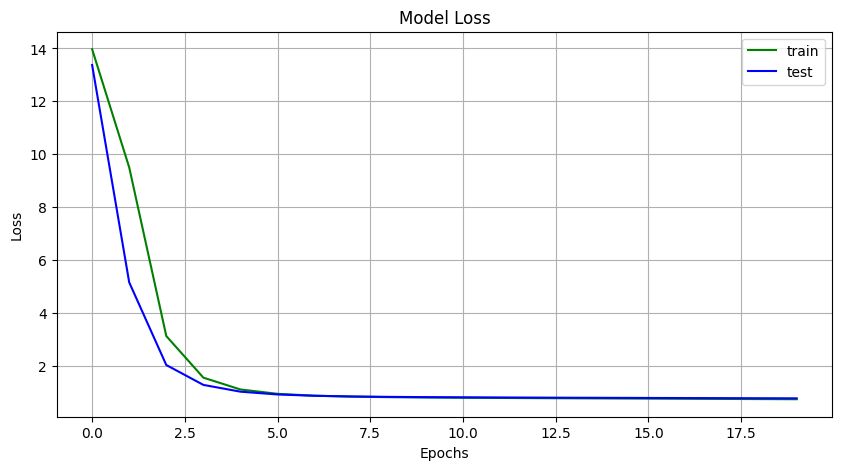

In [122]:
rcParams['figure.figsize'] = 10, 5
plt.plot(model_hist.history['loss'], 'g')
plt.plot(model_hist.history['val_loss'], 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.grid(True)
plt.show()